In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from data.get_data import get_cifar10

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Prepare PyTorch CIFAR-10 dataset
batch_size = 4
train_loader, test_loader = get_cifar10(batch_size)

# CIFAR10 classes
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def show_img(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

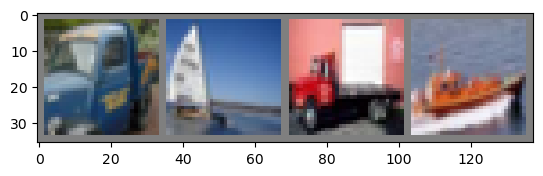

truck, ship , truck, ship 


In [5]:
dateiter = iter(train_loader)
images, labels = next(dateiter)

show_img(torchvision.utils.make_grid(images))

print(", ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In [6]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = torch.flatten(X, 1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return X

In [7]:
network = Network()
network.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)

In [8]:
for epoch in range(2):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 2000 == 1999:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0
            
print("Train finished")

[1,  2000] loss: 2.197
[1,  4000] loss: 1.837
[1,  6000] loss: 1.639
[1,  8000] loss: 1.537
[1, 10000] loss: 1.484
[1, 12000] loss: 1.421
[2,  2000] loss: 1.354
[2,  4000] loss: 1.340
[2,  6000] loss: 1.326
[2,  8000] loss: 1.314
[2, 10000] loss: 1.265
[2, 12000] loss: 1.261
Train finished


In [9]:
MODEL_PATH = "./models/cifar10_example_net.pth"

In [10]:
torch.save(network.state_dict(), MODEL_PATH)

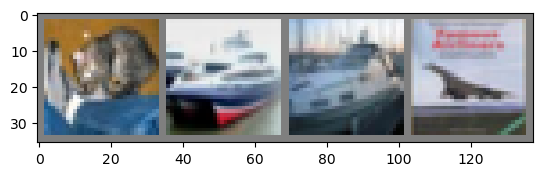

Grounded Truth:  cat   ship  ship  plane


In [11]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

show_img(torchvision.utils.make_grid(images))
print("Grounded Truth: ", " ".join(f"{classes[labels[i]]:5s}" for i in range(4)))

In [12]:
network = Network()
network.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [13]:
outputs = network(images)

_, predicted = torch.max(outputs, 1)
print("Predicted: ", " ".join("%5s" % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship   car  ship


In [14]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = network(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f"Accuracy of 10,000 test images: {100 * correct // total}%")

Accuracy of 10,000 test images: 56%


In [15]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = network(images)
        _, predictions = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
                
            total_pred[classes[label]] += 1
            
for classname, corrent_count in correct_pred.items():
    accuracy = 100 * float(corrent_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f}%")

Accuracy for class: plane is 55.5%
Accuracy for class: car   is 80.8%
Accuracy for class: bird  is 40.2%
Accuracy for class: cat   is 49.5%
Accuracy for class: deer  is 36.1%
Accuracy for class: dog   is 42.7%
Accuracy for class: frog  is 76.7%
Accuracy for class: horse is 59.7%
Accuracy for class: ship  is 78.4%
Accuracy for class: truck is 49.9%
